In [ ]:
# default_exp model.conv

In [ ]:
# hide
import sys

sys.path.append("..")
import pandas as pd

In [ ]:
# hide
from nbdev.showdoc import *

# M5 Base Model

In [ ]:
# export
from fastseq.core import *
from fastseq.data.external import *
from fastseq.data.load import *
from fastseq.data.core import *
from fastseq.data.procs import *
from fastcore.all import *
from fastcore.imports import *
from fastai2.basics import *
from fastai2.data.transforms import *
from fastai2.tabular.core import *
from fastai2.tabular.model import *
from fastai2.torch_basics import *
from fastai2.callback.all import *
from fastseq.metrics import *

In [ ]:
from tqdm import tqdm

In [ ]:
path = Path('../data/m5_tiny/rows')

In [ ]:
list(path.glob('*.json'))[0]

Path('../data/m5_tiny/rows/FOODS_2_164_TX_3.json')

In [ ]:
new_path = Path('../data/m5_tiny/rows2')
if not new_path.exists(): new_path.mkdir()
for f in tqdm(list(path.glob('*.json'))):
    f.copy(new_path / f.name)

# (path / '.ts_meta').copy(new_path / '.ts_meta')

100%|██████████| 299/299 [00:00<00:00, 2203.87it/s]


In [ ]:
path = new_path

{'Train': 43654, 'Val': 17043, 'Validation': 299, 'Evaluation': 299}


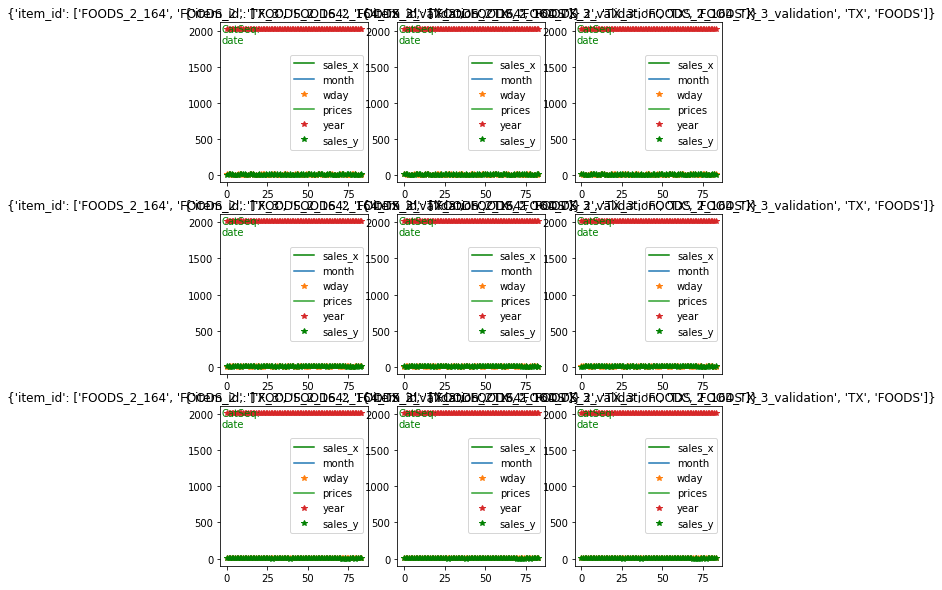

In [ ]:
lookback, horizon = 28*2, 28
dl =  MTSDataLoaders.from_m5_path(path, 'sales', horizon = horizon, lookback = lookback,
                                  train_start = 1600, verbose = True,#after_batch = [NormalizeSeqMulti(n_its=5,skip=[0,5])]
                                 )
dl.show_batch()

In [ ]:
%%time
for o in dl.train:
    pass

CPU times: user 4.48 s, sys: 1.12 s, total: 5.61 s
Wall time: 14.3 s


In [ ]:
for o in dl.train:
    o._dict()
    break

In [ ]:
o[-1].mean(),o[-1].std(),o[0].mean(),o[0].std()

(TensorSeq(-0.0345, device='cuda:0'),
 TensorSeq(0.9519, device='cuda:0'),
 TensorSeq(-6.2997e-08, device='cuda:0'),
 TensorSeq(0.9912, device='cuda:0'))

In [ ]:
# export
class SeqTabConv(Module):
    """Basic model for sequential data."""
    def __init__(self, horizon, lookback, emb_szs = None, emb_szs_ts = None, ts_con_chn = None, con_chn = None,
                 layers = [32, 32], y_range=[-5,10]):
        self.horizon, self.lookback = horizon, lookback
        if emb_szs is not None:
            self.embeds = nn.ModuleList([Embedding(ni, nf) for ni,nf in emb_szs])  
            self.n_emb = sum(e.embedding_dim for e in self.embeds)      
        else:
            self.n_emb=0
            
        if emb_szs is None:
            self.embeds_ts = nn.ModuleList([Embedding(ni, nf) for ni,nf in emb_szs_ts])  
            self.n_emb_ts = sum(e.embedding_dim for e in self.embeds_ts)      
        else:
            self.n_emb_ts=0  
        self.conv = ConvLayer(13, 1, ks = 1, ndim=1)
        self.scale = SigmoidRange(*y_range)

    def forward(self, x, ts_con, ts_cat, cat, con):   
        if self.n_emb != 0:
            x = [e(cat[:,i]) for i,e in enumerate(self.embeds)]
            cat = torch.cat(x, 1)
            print('emb',cat.shape)
            
        cat = cat[:,:,None] * torch.ones(ts_con.shape[0],6,ts_con.shape[-1]).to(default_device())
        print(cat.shape)
        con = con[:,:,None] * torch.ones(ts_con.shape[0],0,ts_con.shape[-1]).to(default_device())        
        ts = torch.cat([ts_con, ts_cat.float(), cat.float(), con], 1)
        r = self.conv(ts)        
        return r

In [ ]:
lookback, horizon = 28*2, 28
mdl = SeqTab(horizon,lookback,
             emb_szs = [(2, 2), (1969, 112), (1969, 112), (2, 2), (299, 39), (199, 31), (3, 3), (3, 3), (7, 5)]
            ).to(default_device())
shape = list(mdl(*o[:-1]).shape)
test_eq(shape,[64,1,lookback+horizon])
print(shape)

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/usr/local/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/local/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/local/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


IndexError: index 6 is out of bounds for dimension 1 with size 6

In [ ]:
#export
def emb_sz_rule(n_cat):
    "Rule of thumb to pick embedding size corresponding to `n_cat`"
    return min(600, round(1.6 * n_cat**0.56))

def _one_emb_sz(classes, n, sz_dict=None):
    "Pick an embedding size for `n` depending on `classes` if not given in `sz_dict`."
    sz_dict = ifnone(sz_dict, {})
    n_cat = len(classes[n])
    sz = sz_dict.get(n, int(emb_sz_rule(n_cat)))  # rule of thumb
    return n_cat,sz

def get_emb_sz(to, sz_dict=None):
    return [_one_emb_sz(to.meta['classes'], key, sz_dict) for key in to.meta['classes'].keys()]

In [ ]:

class M5Learner(Learner): pass

@delegates(M5Learner.__init__)
def SeqTabLearner(dls, layers=None,metrics=None, emb_szs=None, emb_szs_ts=None, **kwargs):
    "Get a `Learner` using `data`, with `metrics`, including a `SeqTab` created using the remaining params."
    if layers is None: layers = [200,100]    
    emb_szs = get_emb_sz(dls.train, {} if emb_szs is None else emb_szs)
    print(emb_szs)
    model = SeqTab(dls.train.horizon, dls.train.lookback, emb_szs = emb_szs,  layers = layers)
    return Learner(dls, model, loss_func = F.mse_loss, opt_func= ranger, metrics=L(metrics)+L(mae, smape,mae), **kwargs)

In [ ]:
learn = SeqTabLearner(dl)

[(2, 2), (1969, 112), (1969, 112), (2, 2), (299, 39), (199, 31), (3, 3), (3, 3), (7, 5)]


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc962a56050>
Traceback (most recent call last):
  File "/home/tako/dev/env37/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/home/tako/dev/env37/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc962a56050>
    w.join()
  File "/usr/local/lib/python3.7/multiprocessing/process.py", line 138, in join
Traceback (most recent call last):
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
  File "/home/tako/dev/env37/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc962a56050>
    self._shutdown_workers()
  File "/home/tako/dev/env37/lib/python3.7/s

(0.0001737800776027143, 4.3651581904669e-07)

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc962a56050>
Traceback (most recent call last):
  File "/home/tako/dev/env37/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/home/tako/dev/env37/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/local/lib/python3.7/multiprocessing/process.py", line 140, in join
    res = self._popen.wait(timeout)
  File "/usr/local/lib/python3.7/multiprocessing/popen_fork.py", line 48, in wait
    return self.poll(os.WNOHANG if timeout == 0.0 else 0)
  File "/usr/local/lib/python3.7/multiprocessing/popen_fork.py", line 28, in poll
    pid, sts = os.waitpid(self.pid, flag)
KeyboardInterrupt: 


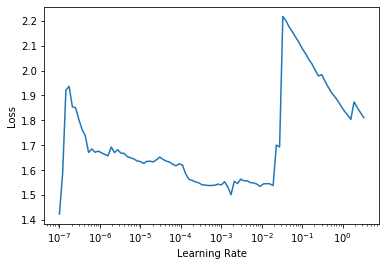

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,mae,smape,mae,time
0,1.348642,1.603091,0.726697,1.911071,0.726697,00:20
1,1.335142,1.596301,0.722016,1.921305,0.722016,00:17


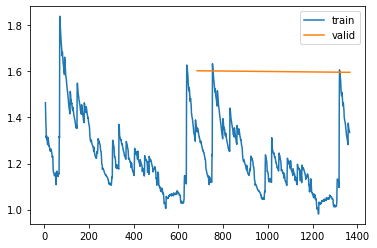

In [ ]:
learn.fit(2, 1e-3)
learn.recorder.plot_loss()

In [ ]:
learn.fit(3, 1e-5)
learn.recorder.plot_loss()

KeyboardInterrupt: 

_______

_______

_______

_______

_______

_______

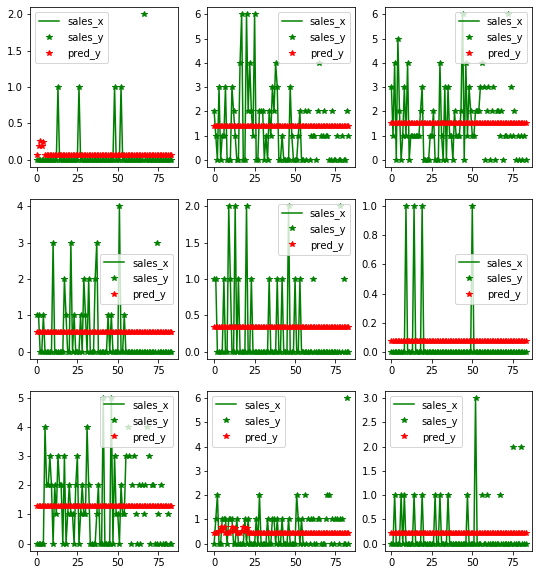

In [ ]:
learn.show_results(show_kwargs = dict(extra = False))

In [ ]:

# inputs,preds,targs,decoded,losses
def make_pred(learn, dl = 2):
    inputs,preds,targs,decoded,losses = learn.get_preds(3, with_decoded = True, with_input=True, with_loss=True)
    predictions = (decoded - targs[:,0,-28:].mean(-1)[:,None,None]).round() #TODO std
    return predictions[:,0,:]
    

In [ ]:

for pred in make_pred(learn, dl = 2):
    o =','.join(L(list(pred[-28:].numpy())).map(int).map(str))
    print(o)
    break
plt.plot(pred)        

In [ ]:
plt.plot(pred[-1,].T)

In [ ]:

def make_submision_file(learn):
    dct = {}
    for i, (file, pred) in enumerate(zip(learn.dls[2].dataset, make_pred(learn, 2))):
        name = file.name.replace('.json','_validation')
        pred =','.join(L(list(pred[-28:].numpy())).map(int).map(str))
        dct[name] = pred

    for i, (file, pred) in enumerate(zip(learn.dls[3].dataset, make_pred(learn, 3))):
        name = file.name.replace('.json','_evaluation')
        pred =','.join(L(list(pred[-28:].numpy())).map(int).map(str))
        dct[name] = pred
    return dct

In [ ]:
# export
dct = make_submision_file(learn)
dct['HOBBIES_1_028_CA_1_validation']

In [ ]:
def make_file(learn, dct):
    with open(learn.path / 'submision_file.csv','w') as f_w:
        with open(Path('../data/m5/sample_submission.csv')) as f:
            f_w.write('id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28')
            for line in f:
                f.write(dct[line.split(',')[0]])
            
M5Learner.make_submision_file = make_submision_file

In [ ]:

make_file(learn, dct)

In [ ]:
!kaggle competitions submit -c m5-forecasting-accuracy -f '../data/m5/rows2/submision_file.csv' -m 'initial sub 0.0.1'

In [ ]:
# hide
from nbdev.export import *
notebook2script()

Converted 00_core.ipynb.
Converted 00_m5.ipynb.
Converted 01_data.external.ipynb.
Converted 02_data.load.ipynb.
Converted 03_data.core.ipynb.
Converted 04_data.procs.ipynb.
Converted 05_data.m5.ipynb.
Converted 10_model.base.ipynb.
Converted 11_metrics.ipynb.
Converted 11_model.conv.ipynb.
Converted 12_compare.ipynb.
Converted index.ipynb.
Converted tab.model.ipynb.


In [ ]:
git_add('11_model.conv.ipynb', commit_msg='nice start')

Converted 11_model.conv.ipynb.


['/home/tako/dev/fastseq/fastseq/model/conv.py',
 '/home/tako/dev/fastseq/nbs/11_model.conv.ipynb']